In [36]:
## personal imports
from processor.processor import Processor as p
from database.market import Market
from database.adatabase import ADatabase
from datetime import datetime

from tradealgorithm.tradealgorithm import TradeAlgorithm
from tradealgorithm.tradealgorithmfactory import TradeAlgorithmFactory
from pricer.pricer_factory import PricerFactory
from pricer.pricer import Pricer
from ranker.ranker_factory import RankerFactory
from ranker.ranker import Ranker
from classifier.classifier_factory import ClassifierFactory
from classifier.classifier import Classifier
from datetime import datetime

## risk and return class imports
from returns.products import Products as returns_products_class

## standard imports
from statistics import variance
import math
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [37]:
start = datetime(2001,1,1)
end  = datetime(2023,1,1)
current_date = datetime(2023,1,1)

In [38]:
market = Market()

In [39]:
pricer_classes = [] 
pricer_classes.append(Pricer.DAILY_STOCK_MEANREVERSION)
pricer_classes.append(Pricer.DAILY_STOCK_DEVROLLING)
pricer_classes.append(Pricer.DAILY_STOCK_BREAKOUT)
# pricer_classes.append(Pricer.DAILY_STOCK_WINDOW)
# pricer_classes.append(Pricer.DAILY_STOCK_ROLLING)

In [40]:
market.connect()
sp500 = market.retrieve("sp500")
market.disconnect()
sp500 = sp500.rename(columns={"Symbol":"ticker"})

In [41]:
market.connect()
tyields = returns_products_class.tyields(market.retrieve("tyields10"),10)
bench_returns = returns_products_class.spy_bench(market.retrieve("spy"))
market.disconnect()
current = False
ranker_class = Ranker.NONE
classifier_class = Classifier.NONE

In [42]:
analysis = []
trade_algos = []
for pricer_class in tqdm(pricer_classes):
    trade_algo = TradeAlgorithmFactory.build(TradeAlgorithm.RRR_BETA)
    trade_algo.initialize(pricer_class,ranker_class,classifier_class,start,end,current_date)
    trade_algo.initialize_bench_and_yields()
    trade_algo.initialize_classes()
    trade_algos.append(trade_algo)
    trade_algo.db.connect()
    parameters = trade_algo.pull_iterations().to_dict("records")
    for parameter in tqdm(parameters):
        try:
            trade = trade_algo.db.query("trades",{"iteration":parameter["iteration"]})
            if trade.index.size > 0:
                positions = int(trade_algo.positions) if trade_algo.pricer_class.asset_class.value == "stocks" else 1
                pricer_timeframe =  trade_algo.pricer_class.time_horizon_class.naming_convention
                trade = trade[trade["position"] <= positions]
                ledger = trade.sort_values(["year",pricer_timeframe]).copy()
                anas = trade_algo.analysis
                if ledger.index.size > 0:
                    cumulative = anas.trade_analysis(ledger,positions,tyields,bench_returns)
                    for key in parameter.keys():
                        cumulative[key] = parameter[key]
                    cumulative["trade_algo"] = trade_algo.name
                    for key in parameter.keys():
                        cumulative[key] = parameter[key]
                    analysis.append(cumulative[list(parameter.keys()) + ["trade_algo","pv","beta","rrr","sharpe"]].iloc[-1])
        except Exception as e:
            print(str(e))
            continue
    trade_algo.db.disconnect()
a = pd.DataFrame([x.to_dict() for x in analysis])

 50%|████████████████████████████████████████████████████████████████████████                                                                         | 156/314 [00:05<00:06, 26.09it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 240/314 [01:02<02:15,  1.84s/it]


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 293/314 [02:14<00:38,  1.85s/it]


 33%|█████████████████████████████████████████████████▎                                                                                                  | 1/3 [02:54<05:48, 174.42s/it]
0it [00:00, ?it/s]
 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 2/3 [02:54<01:12, 72.10s/it]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:55<00:00, 58.50s/it]


In [43]:
a.sort_values("pv",ascending=False).head(20)

,value,ceiling,classification,rank,risk,floor_value,tyields,buy_day,iteration,trade_algo,pv,beta,rrr,sharpe
313,False,False,False,False,flat,0.5,tyield10,3,313,dsmr_n_n_b_r,6942.379090,-0.018619,0.979369,-372809.932596
306,False,False,False,False,flat,0.5,tyield2,1,306,dsmr_n_n_b_r,6942.379090,-0.018619,0.979369,-372809.932596
301,False,False,False,False,flat,0.5,tyield1,1,301,dsmr_n_n_b_r,6942.379090,-0.018619,0.979369,-372809.932596
302,False,False,False,False,flat,0.5,tyield1,2,302,dsmr_n_n_b_r,6942.379090,-0.018619,0.979369,-372809.932596
303,False,False,False,False,flat,0.5,tyield1,3,303,dsmr_n_n_b_r,6942.379090,-0.018619,0.979369,-372809.932596
304,False,False,False,False,flat,0.5,tyield1,4,304,dsmr_n_n_b_r,6942.379090,-0.018619,0.979369,-372809.932596
305,False,False,False,False,flat,0.5,tyield2,0,305,dsmr_n_n_b_r,6942.379090,-0.018619,0.979369,-372809.932596
300,False,False,False,False,flat,0.5,tyield1,0,300,dsmr_n_n_b_r,6942.379090,-0.018619,0.979369,-372809.932596
307,False,False,False,False,flat,0.5,tyield2,2,307,dsmr_n_n_b_r,6942.379090,-0.018619,0.979369,-372809.932596
309,False,False,False,False,flat,0.5,tyield2,4,309,dsmr_n_n_b_r,6942.379090,-0.018619,0.979369,-372809.932596


In [44]:
top_by_strategy = a.sort_values("pv",ascending=False).groupby("trade_algo").nth(0).reset_index().sort_values("pv",ascending=False)
top_by_strategy

,trade_algo,value,ceiling,classification,rank,risk,floor_value,tyields,buy_day,iteration,pv,beta,rrr,sharpe
0,dsmr_n_n_b_r,False,False,False,False,flat,0.5,tyield10,3,313,6942.37909,-0.018619,0.979369,-372809.932596


In [45]:
for row in top_by_strategy.iterrows():
    algo_name = row[1]["trade_algo"]
    parameter = row[1]
    db = ADatabase(algo_name)
    db.connect()
    db.drop("optimal")
    db.store("optimal",pd.DataFrame([row[1].to_dict()]))
    db.disconnect()

In [46]:
top = a.sort_values("pv",ascending=False).iloc[0]
db = ADatabase(top["trade_algo"])
db.connect()
analysis = db.query("trades",{"iteration":int(top["iteration"])})
db.disconnect()

In [47]:
trade_algo_name = top["trade_algo"]
trade_algo_class = [x for x in trade_algos if x.name == trade_algo_name][0]
anas = trade_algo_class.analysis
naming = trade_algo_class.pricer_class.time_horizon_class.naming_convention
positions = int(int(analysis["position"].max()))
ledger = analysis[["year",naming,"ticker",f"{naming}ly_delta",f"{naming}ly_delta_sign","actual_returns","position"]]
ledger = ledger[(ledger["year"]>=start.year)]
ledger = ledger.merge(sp500[["ticker","GICS Sector","Security"]],on="ticker",how="left")

In [48]:
ledger

,year,date,ticker,dately_delta,dately_delta_sign,actual_returns,position,GICS Sector,Security
0,2001,2001-01-02,AMZN,1.266945,1.0,1.265130,0,Consumer Discretionary,Amazon
1,2001,2001-01-03,AMZN,1.264470,1.0,0.882688,0,Consumer Discretionary,Amazon
2,2001,2001-01-04,AMZN,1.201575,1.0,0.939355,0,Consumer Discretionary,Amazon
3,2001,2001-01-05,AMZN,1.241348,1.0,1.026099,0,Consumer Discretionary,Amazon
4,2001,2001-01-08,AMZN,1.246775,1.0,1.096386,0,Consumer Discretionary,Amazon
...,...,...,...,...,...,...,...,...,...
112615,2023,2023-07-19,PFE,1.000284,1.0,1.009056,19,Health Care,Pfizer
112616,2023,2023-07-20,ALL,1.000227,1.0,0.989641,19,Financials,Allstate
112617,2023,2023-07-21,STX,1.000219,1.0,0.994464,19,Information Technology,Seagate Technology
112618,2023,2023-07-25,FOXA,1.000339,1.0,1.005460,19,Communication Services,Fox Corporation (Class A)


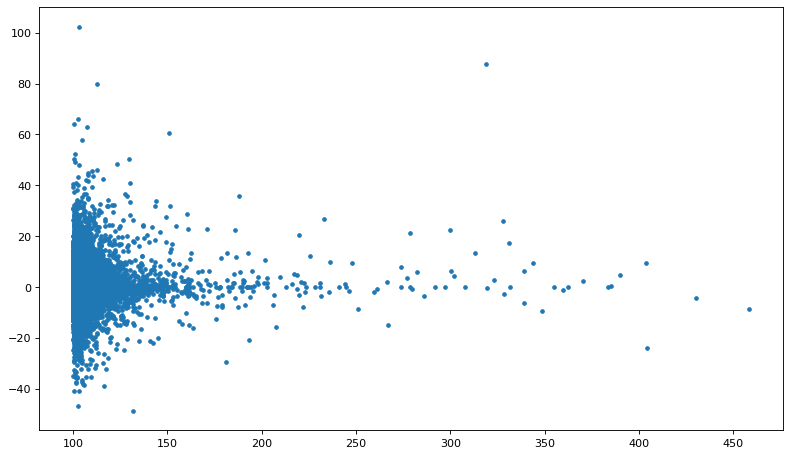

In [49]:
plt.figure(figsize=(12, 7), dpi=80)
plt.scatter(ledger[f"{naming}ly_delta"] * 100, (ledger["actual_returns"]-1)*100,s=10)

In [50]:
ledger.sort_values(["year",naming,"position"],ascending=True).head(40)

,year,date,ticker,dately_delta,dately_delta_sign,actual_returns,position,GICS Sector,Security
0,2001,2001-01-02,AMZN,1.266945,1.0,1.265130,0,Consumer Discretionary,Amazon
5631,2001,2001-01-02,PENN,1.265959,1.0,0.969932,1,Consumer Discretionary,Penn National Gaming
11262,2001,2001-01-02,NVDA,1.112952,1.0,1.306947,2,Information Technology,Nvidia
16893,2001,2001-01-02,APH,1.091802,1.0,1.026103,3,Information Technology,Amphenol
22524,2001,2001-01-02,FFIV,1.082473,1.0,1.268293,4,Information Technology,"F5, Inc."
28155,2001,2001-01-02,CTSH,1.067566,1.0,1.184727,5,Information Technology,Cognizant
33786,2001,2001-01-02,TYL,1.043370,1.0,1.036000,6,Information Technology,Tyler Technologies
39417,2001,2001-01-02,NLOK,1.038669,1.0,1.171335,7,Information Technology,NortonLifeLock
45048,2001,2001-01-02,WDC,1.037304,1.0,1.216169,8,Information Technology,Western Digital
50679,2001,2001-01-02,ODFL,1.034804,1.0,1.017769,9,Industrials,Old Dominion


In [51]:
ledger[ledger["position"]<20].sort_values("actual_returns",ascending=False).head(50)

,year,date,ticker,dately_delta,dately_delta_sign,actual_returns,position,GICS Sector,Security
41394,2008,2008-12-04,HIG,1.033655,1.0,2.023578,7,Financials,Hartford (The)
6019,2002,2002-07-26,WMB,3.189422,1.0,1.877358,1,Energy,Williams Companies
13214,2008,2008-10-28,LVS,1.125683,1.0,1.800000,2,Consumer Discretionary,Las Vegas Sands
92140,2009,2009-03-13,AIG,1.028021,1.0,1.660000,16,Financials,American International Group
18944,2009,2009-03-24,CBRE,1.005222,1.0,1.640000,3,Real Estate,CBRE Group
62327,2002,2002-07-24,CNP,1.072818,1.0,1.629630,11,Utilities,CenterPoint Energy
7650,2009,2009-02-05,FITB,1.507116,1.0,1.603659,1,Financials,Fifth Third Bank
18848,2008,2008-10-31,HIG,1.048149,1.0,1.577519,3,Financials,Hartford (The)
3819,2016,2016-04-21,AMD,1.010931,1.0,1.522901,0,Information Technology,AMD
1976,2008,2008-12-03,DXCM,1.298674,1.0,1.502513,0,Health Care,Dexcom


In [52]:
ledger["actual_returns"].mean()

1.0014994961841892

In [53]:
ledger[ledger["actual_returns"]>1].index.size / ledger.index.size

0.5081868229444149

In [54]:
portfolio = ledger.pivot_table(index=["year",naming],columns="position",values="actual_returns").fillna(1).reset_index()

In [55]:
portfolio.head(20)

position,year,date,0,1,2,3,4,5,6,7,...,10,11,12,13,14,15,16,17,18,19
0,2001,2001-01-02,1.265130,0.969932,1.306947,1.026103,1.268293,1.184727,1.036000,1.171335,...,1.013028,1.072304,1.283688,1.089565,1.050000,0.905574,0.816667,1.032967,1.002497,1.100134
1,2001,2001-01-03,0.882688,0.981300,1.115001,1.042992,1.134615,1.011210,0.977366,1.155350,...,0.994095,0.877551,1.012609,1.071823,0.851794,0.936403,1.005106,0.969474,0.861031,0.930446
2,2001,2001-01-04,0.939355,0.974524,0.916098,0.792542,0.850103,1.000000,0.959070,0.845011,...,1.065913,0.938835,1.007825,0.963167,0.931034,0.886598,1.003534,0.989247,1.015074,0.994255
3,2001,2001-01-05,1.026099,1.013071,0.929573,1.003158,0.924722,1.163919,1.041800,0.743300,...,0.925212,1.000000,1.116197,1.002291,1.013970,0.958333,1.018024,1.016527,1.022605,1.061739
4,2001,2001-01-08,1.096386,1.058010,0.994115,1.009969,0.971831,0.927500,1.040703,0.987222,...,0.941851,1.089781,0.991438,0.969333,0.991803,1.000000,1.103596,0.993486,0.956140,1.007470
5,2001,2001-01-09,1.007326,1.036996,0.975610,1.217391,1.029091,1.010782,0.983111,1.040193,...,1.016674,0.973884,1.120587,1.028636,0.990034,0.985329,0.987182,0.992586,0.975519,1.076362
6,2001,2001-01-10,1.015697,1.030303,1.274286,1.188000,0.933333,0.993942,1.009660,1.026153,...,1.110816,0.994343,0.945637,0.933775,0.920808,1.070000,0.979726,1.068320,0.920241,1.020458
7,2001,2001-01-11,1.047418,1.040588,0.971599,0.970476,1.005025,1.083429,1.000000,0.987156,...,0.955849,1.016365,1.027462,1.019574,1.051677,1.087390,1.024614,1.022495,1.010445,1.009714
8,2001,2001-01-12,1.093058,1.038462,0.938469,1.020916,0.968121,1.006711,1.005000,0.984753,...,1.040952,1.013409,0.991091,0.968559,0.998211,1.000000,0.978000,0.993204,0.983965,0.979706
9,2001,2001-01-16,0.907961,0.928056,0.971115,1.115556,1.028103,0.992404,0.981359,1.002477,...,1.067993,1.012640,0.998464,1.014074,1.020131,0.993865,0.984694,0.955657,1.054955,0.994146


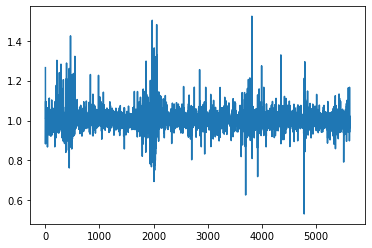

In [56]:
plt.plot(portfolio[0])

In [57]:
positions = 20

In [58]:
cumulative = anas.iteration_analysis(portfolio,positions,bench_returns)

In [59]:
anas.naming

'date'

In [60]:
cumulative.tail(10)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,year,date,pv,daily_returns,adjclose,bench
5621,74921.968428,44619.762035,3130.006736,42.955724,19457.975248,743.543975,1.242118,173.291091,327.346842,406.745843,...,8.186540,164.098803,2.557967,1342.766462,2023,2023-07-11,7274.340322,1.004197,13760.70,6.004163
5622,75656.497530,45025.806381,3130.006736,43.039273,19394.985922,729.320509,1.248897,173.821470,334.452546,411.464324,...,8.263730,163.063182,2.606243,1375.619155,2023,2023-07-12,7329.690188,1.005150,13918.96,6.073216
5623,67943.941957,43179.510088,3114.325339,43.349595,19042.248015,722.116782,1.239105,176.641260,336.650568,405.472684,...,8.218617,158.443927,2.582332,1381.873154,2023,2023-07-13,6832.933771,0.987659,14138.57,6.169037
5624,62434.973690,40290.949758,2880.819617,43.131319,19561.729631,723.481698,1.223412,177.748321,330.306393,405.378136,...,8.083095,157.679840,2.561880,1405.163151,2023,2023-07-14,6428.274258,0.988760,14113.70,6.158186
5625,72840.802638,43705.944756,3032.582658,43.603692,19792.654057,730.247726,1.224180,181.264576,325.922893,407.615322,...,8.268329,158.601944,2.602771,1403.909660,2023,2023-07-18,7138.941593,1.022878,14353.64,6.262878
5626,73226.203711,43915.637431,3003.122774,43.387220,19798.152016,723.240055,1.244100,190.065614,325.956974,413.255430,...,8.353968,161.366328,2.580054,1416.623441,2023,2023-07-19,7168.773008,1.010674,14358.02,6.264789
5627,73226.203711,44215.198396,2981.717765,43.696760,19324.988635,725.173205,1.245225,188.218267,325.632593,415.627591,...,8.473180,162.115345,2.609084,1401.948649,2023,2023-07-20,7158.521686,1.001906,14063.31,6.136199
5628,70528.396205,44784.364229,3020.246781,43.825735,19275.181963,724.518323,1.218669,186.054232,330.127592,415.253039,...,8.804114,161.036808,2.571267,1394.187484,2023,2023-07-21,7051.151783,0.998801,14032.81,6.122891
5629,72122.258267,45081.167821,3088.974342,44.115274,19392.395907,743.231048,1.246884,186.752498,331.091750,420.012386,...,8.745721,160.246422,2.598169,1401.799063,2023,2023-07-25,7156.631191,1.007988,14144.56,6.171651
5630,68137.603114,45279.036883,3149.228642,43.615161,18829.027401,767.233410,1.280503,181.986484,328.815519,410.349900,...,8.642757,160.635488,2.785513,1399.684735,2023,2023-07-26,6942.379090,0.997468,14127.28,6.164111


In [61]:
cash_analysis = cumulative.copy()
cash_analysis["previous_day"] = cash_analysis["daily_returns"].shift(1)
cash_analysis["base"] = [min(row[1]["previous_day"],1) for row in cash_analysis.iterrows()]
cash_analysis["real_return"] = cash_analysis["base"] * cash_analysis["daily_returns"]
cash_analysis["cash"] = [max(0,row[1]["real_return"]-1) * 100 for row in cash_analysis.iterrows()]
cash_analysis["running_cash"] = cash_analysis["cash"].cumsum()

In [62]:
cash_analysis["cash"].sum()

3030.189761227401

In [63]:
cash_analysis[["daily_returns","base","real_return","cash","running_cash"]]

,daily_returns,base,real_return,cash,running_cash
0,1.091441,NaN,NaN,0.000000,0.000000
1,0.985596,1.000000,0.985596,0.000000,0.000000
2,0.952369,0.985596,0.938651,0.000000,0.000000
3,1.003129,0.952369,0.955349,0.000000,0.000000
4,1.006700,1.000000,1.006700,0.669975,0.669975
...,...,...,...,...,...
5626,1.010674,1.000000,1.010674,1.067356,3029.321213
5627,1.001906,1.000000,1.001906,0.190586,3029.511799
5628,0.998801,1.000000,0.998801,0.000000,3029.511799
5629,1.007988,0.998801,1.006780,0.677962,3030.189761


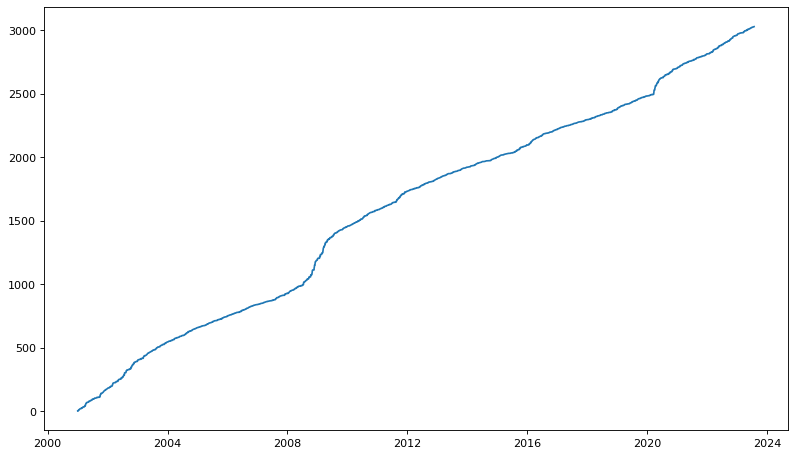

In [64]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(cash_analysis["date"],cash_analysis["running_cash"])

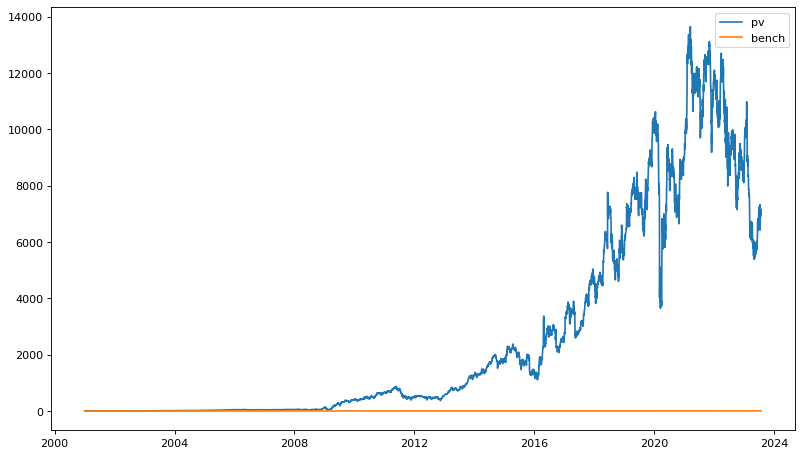

In [65]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(cumulative["date"],cumulative["pv"])
plt.plot(cumulative["date"],cumulative["bench"])
plt.legend(["pv","bench"])

In [66]:
cumulative.head(20)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,year,date,pv,daily_returns,adjclose,bench
0,1.265130,0.969932,1.306947,1.026103,1.268293,1.184727,1.036000,1.171335,1.216169,1.017769,...,0.816667,1.032967,1.002497,1.100134,2001,2001-01-02,1.091441,1.091441,2291.86,1.000000
1,1.116715,0.951794,1.457248,1.070217,1.439024,1.198008,1.012551,1.353302,1.067667,1.041352,...,0.820837,1.001434,0.863181,1.023616,2001,2001-01-03,1.078753,0.985596,2616.69,1.141732
2,1.048991,0.927546,1.334981,0.848192,1.223319,1.198008,0.971107,1.143555,0.949939,1.130341,...,0.823737,0.990666,0.876193,1.017736,2001,2001-01-04,1.023028,0.952369,2566.83,1.119977
3,1.076369,0.939670,1.240962,0.850871,1.131230,1.394384,1.011700,0.850004,1.040605,1.115194,...,0.838584,1.007039,0.895999,1.080570,2001,2001-01-05,1.025213,1.003129,2407.65,1.050522
4,1.180115,0.994180,1.233660,0.859352,1.099364,1.293291,1.052879,0.839143,1.078760,1.078051,...,0.925459,1.000479,0.856701,1.088642,2001,2001-01-08,1.028935,1.006700,2395.92,1.045404
5,1.188761,1.030961,1.203570,1.046168,1.131346,1.307235,1.035097,0.872870,1.107263,1.147819,...,0.913596,0.993061,0.835728,1.171772,2001,2001-01-09,1.058076,1.026922,2441.30,1.065205
6,1.207421,1.062202,1.533692,1.242848,1.055923,1.299316,1.045096,0.895699,1.195363,1.214738,...,0.895074,1.060907,0.769071,1.195745,2001,2001-01-10,1.088536,1.028668,2524.18,1.101367
7,1.264675,1.105315,1.490135,1.206154,1.061229,1.407717,1.045096,0.884195,1.195363,1.171677,...,0.917105,1.084772,0.777104,1.207360,2001,2001-01-11,1.102636,1.014791,2640.57,1.152152
8,1.382364,1.147827,1.398445,1.231382,1.027398,1.417164,1.050321,0.870713,1.187582,1.167512,...,0.896928,1.077400,0.764644,1.182858,2001,2001-01-12,1.102113,0.999626,2626.50,1.146012
9,1.255133,1.065248,1.358051,1.373675,1.056271,1.406399,1.030742,0.872870,1.247587,1.154497,...,0.883200,1.029626,0.806665,1.175934,2001,2001-01-16,1.103124,1.003152,2618.55,1.142544


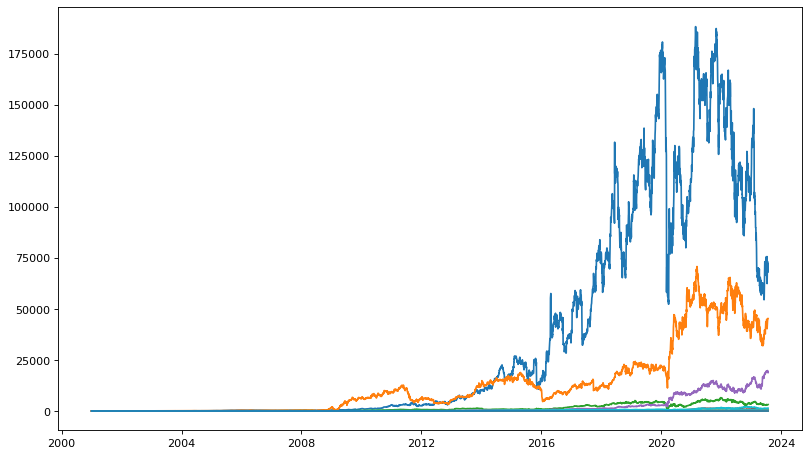

In [67]:
plt.figure(figsize=(12, 7), dpi=80)
position_columns = [x for x in cumulative.columns if x not in ["year","week","quarter","date_string","date","pv","adjclose","bench"]]
for i in position_columns:
    position = cumulative[i]
    plt.plot(cumulative["date"],position)
plt.show()


In [68]:
ledger.groupby(["GICS Sector"]).mean().sort_values("actual_returns",ascending=False)

,year,dately_delta,dately_delta_sign,actual_returns,position
GICS Sector,,,,,
Financials,2012.941239,1.008535,1.0,1.002295,10.195772
Real Estate,2011.906772,1.019907,1.0,1.001938,10.785406
Health Care,2009.617645,1.012092,1.0,1.001846,9.434164
Consumer Staples,2011.572413,1.040520,1.0,1.001650,9.688626
Consumer Discretionary,2012.324006,1.010193,1.0,1.001587,9.230382
Utilities,2012.336856,1.007354,1.0,1.001482,10.839925
Industrials,2010.308380,1.010718,1.0,1.001463,9.597300
Information Technology,2010.587795,1.014514,1.0,1.001364,8.811800
Energy,2014.550363,1.008741,1.0,1.001058,9.457814


In [69]:
ledger.groupby(["year",naming,"ticker","Security"]).prod().sort_values("actual_returns",ascending=False).head(30)

dately_delta  \
year date       ticker Security                                       
2008 2008-12-04 HIG    Hartford (The)                      1.033655   
2002 2002-07-26 WMB    Williams Companies                  3.189422   
2008 2008-10-28 LVS    Las Vegas Sands                     1.125683   
2009 2009-03-13 AIG    American International Group        1.028021   
     2009-03-24 CBRE   CBRE Group                          1.005222   
2002 2002-07-24 CNP    CenterPoint Energy                  1.072818   
2009 2009-02-05 FITB   Fifth Third Bank                    1.507116   
2008 2008-10-31 HIG    Hartford (The)                      1.048149   
2016 2016-04-21 AMD    AMD                                 1.010931   
2008 2008-12-03 DXCM   Dexcom                              1.298674   
2006 2006-02-02 IRM    Iron Mountain                       1.004061   
2004 2004-08-02 CMCSA  Comcast                             1.007205   
2009 2009-02-05 RF     Regions Financial Corporation       1.231605   
     2009-04-02 MGM    MGM Resorts                         1.028865   
2002 2002-07-25 JCI    Johnson Controls                    1.125313   
     2002-03-06 SBAC   SBA Communications                  1.100189   
2008 2008-11-21 CBRE   CBRE Group                          1.076598   
2020 2020-03-23 CZR    Caesars Entertainment               1.078540   
2008 2008-11-24 LNC    Lincoln Financial                   1.107172   
     2008-09-18 AIG    American International Group        1.024911   
2002 2002-11-14 ALGN   Align Technology                    1.158622   
2020 2020-03-23 NCLH   Norwegian Cruise Line Holdings      1.068038   
2008 2008-07-15 UAL    United Airlines Holdings            1.079420   
2002 2002-07-26 AES    AES Corporation                     1.303668   
2008 2008-12-04 PFG    Principal Financial Group           1.014743   
2014 2014-06-23 VRTX   Vertex Pharmaceuticals              1.001196   
2008 2008-07-16 HBAN   Huntington National Bank            1.024304   
2002 2002-10-30 AES    AES Corporation                     1.098102   
2020 2020-11-06 CCL    Carnival                            1.001529   
     2020-03-23 BBWI   Bath & Body Works, Inc.             1.058162   

                                                       dately_delta_sign  \
year date       ticker Security                                            
2008 2008-12-04 HIG    Hartford (The)                                1.0   
2002 2002-07-26 WMB    Williams Companies                            1.0   
2008 2008-10-28 LVS    Las Vegas Sands                               1.0   
2009 2009-03-13 AIG    American International Group                  1.0   
     2009-03-24 CBRE   CBRE Group                                    1.0   
2002 2002-07-24 CNP    CenterPoint Energy                            1.0   
2009 2009-02-05 FITB   Fifth Third Bank                              1.0   
2008 2008-10-31 HIG    Hartford (The)                                1.0   
2016 2016-04-21 AMD    AMD                                           1.0   
2008 2008-12-03 DXCM   Dexcom                                        1.0   
2006 2006-02-02 IRM    Iron Mountain                                 1.0   
2004 2004-08-02 CMCSA  Comcast                                       1.0   
2009 2009-02-05 RF     Regions Financial Corporation                 1.0   
     2009-04-02 MGM    MGM Resorts                                   1.0   
2002 2002-07-25 JCI    Johnson Controls                              1.0   
     2002-03-06 SBAC   SBA Communications                            1.0   
2008 2008-11-21 CBRE   CBRE Group                                    1.0   
2020 2020-03-23 CZR    Caesars Entertainment                         1.0   
2008 2008-11-24 LNC    Lincoln Financial                             1.0   
     2008-09-18 AIG    American International Group                  1.0   
2002 2002-11-14 ALGN   Align Technology                              1.0   
2020 2020-03-23 NCLH   Norwegian C

In [70]:
industry_analysis = ledger.pivot_table(index=["year",naming],columns="GICS Sector",values="actual_returns").fillna(1).reset_index()
industry_analysis[[x for x in industry_analysis.columns if x != "sell_date"]].cumprod()

GICS Sector,year,date,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
0,2001,2001-01-02 00:00:00.000000000,1.000000,1.152079,1.000000,1.000000,1.000000,1.009293,1.016565,1.163714,1.000000,1.000000,0.816667
1,4004001,2252-06-29 23:17:13.297436672,1.000000,1.098422,1.000000,1.000000,1.000000,0.968551,0.997639,1.206372,1.000000,1.000000,0.716667
2,8012006001,2159-09-27 04:21:44.589074432,1.000000,1.079247,1.003534,1.000000,1.000000,0.905472,0.987992,1.080674,1.000000,1.000000,0.687333
3,16032024008001,1970-01-01 00:00:00.000000000,1.000000,1.088871,1.120141,1.000000,1.018024,0.784165,0.989552,1.098986,1.000000,1.000000,0.800000
4,32080080040010001,1970-01-01 00:00:00.000000000,1.000000,1.139511,1.110550,1.000000,1.009680,0.784677,0.978006,1.111513,1.000000,1.000000,0.780922
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5626,0,1970-01-01 00:00:00.000000000,11.687808,1111.294370,90.715734,17.460529,130.688197,447.103458,165.203089,369.969467,4.390656,19.438525,10.852041
5627,0,1970-01-01 00:00:00.000000000,11.690865,1111.323063,91.356257,17.541576,130.344692,454.271558,165.203089,370.631118,4.369170,19.438525,10.852041
5628,0,1970-01-01 00:00:00.000000000,11.613805,1112.155645,91.273929,17.541576,131.689670,447.687316,165.203089,367.200893,4.380648,20.197729,10.852041
5629,0,1970-01-01 00:00:00.000000000,11.762124,1129.140482,91.273929,17.541576,131.482006,447.687316,165.200950,367.457754,4.359147,20.197729,10.852041
